#  Прогнозирование заказов такси

**Задача:** спрогнозировать количество заказов такси на следующий час

**Цель:** построить модель для своевременного привлечения водителей в период пиковой нагрузки

**Исторические данные:** исторические данные о заказах такси в аэропортах за март-август 2018г

**Действия:** Предподготовка данных. Ресемплирование. Построить несколько моделей и выбрать наилучшую модель, где RMSE меньше 48

## Подготовка

In [1]:
# подгрузим необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# подгрузим данные

data = pd.read_csv('/datasets/taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
# в датесете 2 колонки. Сделаем временной индекс по колонке datetime

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# получим информацию по данным. Пропусков нет. ТИп данных соответствует данным

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# проверим в хронологическом ли порядке расположены даты

data = data.sort_index()
print(data.index.is_monotonic)

True


In [6]:
# выгрузим статистические данные. Максимальное кол-во заказов приходится менее чем на 25 % всех данных

data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Вывод
В данных около 27тыс значений, более чем достаточно для анализа. В данных один признак и один целевой признак. Данные представлены за пол года с 03.2018 по 08.2018.
Пропусков в данных нет.
Создали временной индекс за счет данных datetime. 

## Анализ

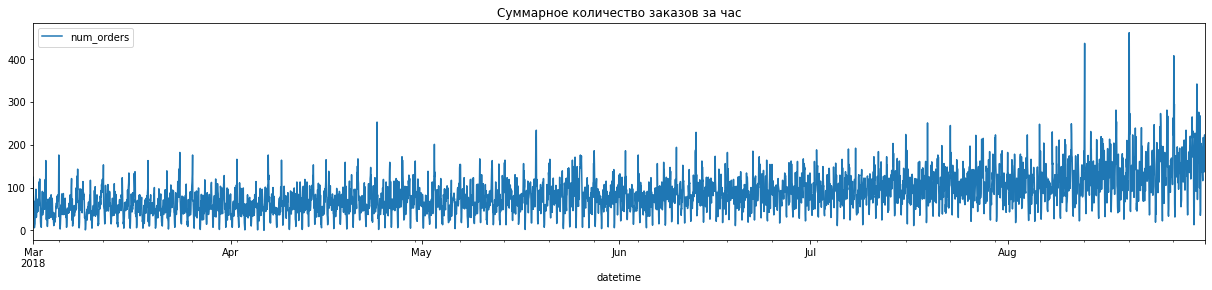

In [7]:
#В связи с тем, что нам нужно спрогнозировать кол-во заказов на час, ресемплируем данные по 1 часу

data = data.resample('1H').sum()
figsize = (21,4)
data.plot(figsize=figsize)
plt.title('Суммарное количество заказов за час')
plt.show()


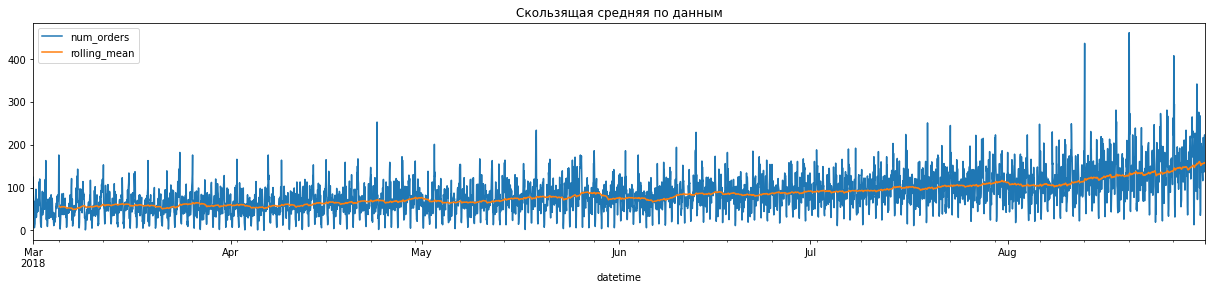

In [8]:
#отобразим скользящую среднюю, чтоб наглядно увидель закономерность.

data['rolling_mean'] = data.rolling(100).mean()
data.plot(figsize=figsize)
plt.title('Скользящая средняя по данным')
plt.show()

/tmp/ipykernel_34/1116282596.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_aug = data['2018-08'].plot(figsize=figsize);


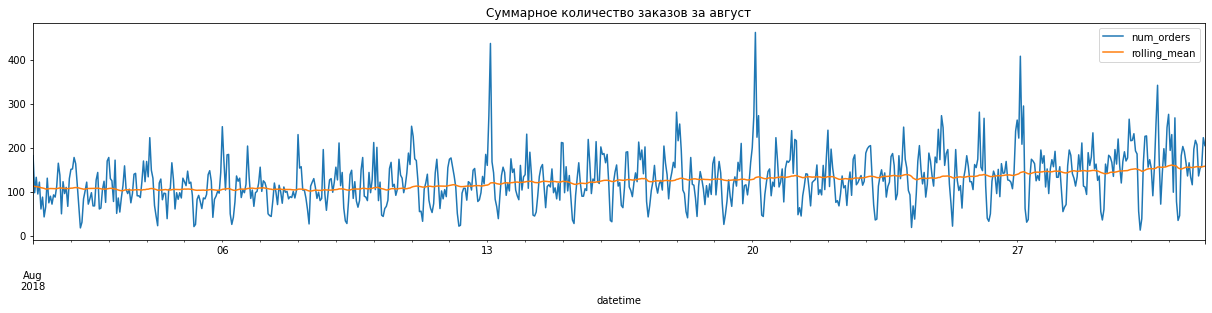

In [9]:
# Наблюдается увеличение заказов ближе к августу. Выведем данные за последний месяц, т.е август

data_aug = data['2018-08'].plot(figsize=figsize);
plt.title('Суммарное количество заказов за август')
plt.show()

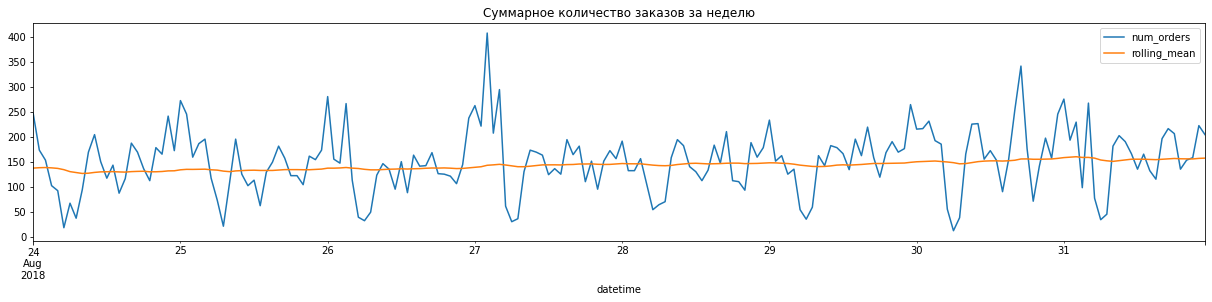

In [10]:
# Наблюдается активность  с определенной частотой. Выведем данные за неделю

figsize = (21,4)
data['2018-08-24':].plot(figsize=figsize);
plt.title('Суммарное количество заказов за неделю')
plt.show()

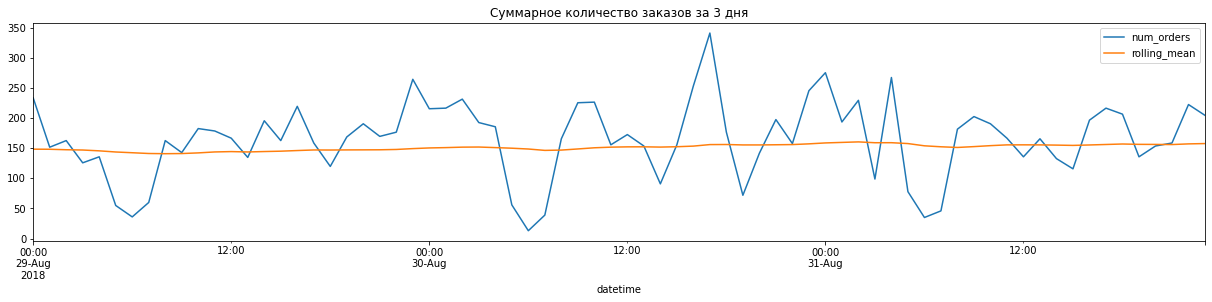

In [11]:
# В течение недели также наблюдается активность с определенной частотой. Выведем данные за 3 дня


figsize = (21,4)
data['2018-08-29':].plot(figsize=figsize);
plt.title('Суммарное количество заказов за 3 дня')
plt.show()

# Наблюдается спад заказов ночью ближе к 6  утра и в течение дня в определенные интервалы. 

In [12]:
# декомпозируем данные чтоб определить тренд и сезонность

decomposed = seasonal_decompose((data.drop(['rolling_mean'], axis = 1)))

Text(0.5, 1.0, 'Trend')

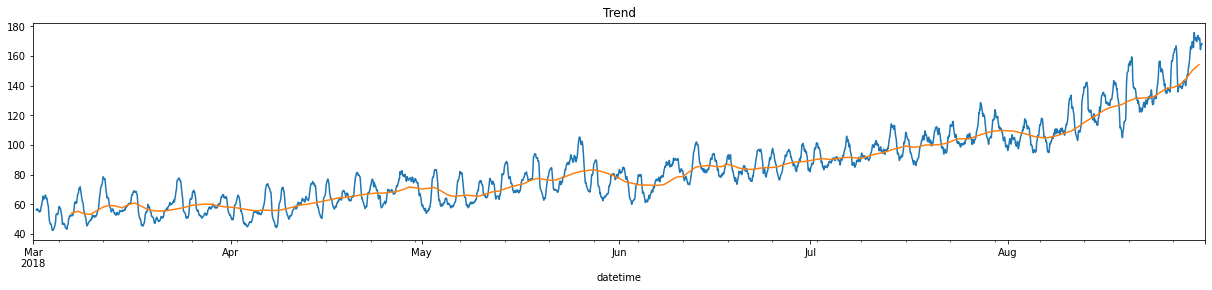

In [13]:
# Добавим скользящее среднее с разбивкой на недельные заказы

figsize = (21,4)
decomposed.trend.plot(ax=plt.gca(), figsize=figsize)
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=figsize);
plt.title('Trend')

Text(0.5, 1.0, 'Seasonal')

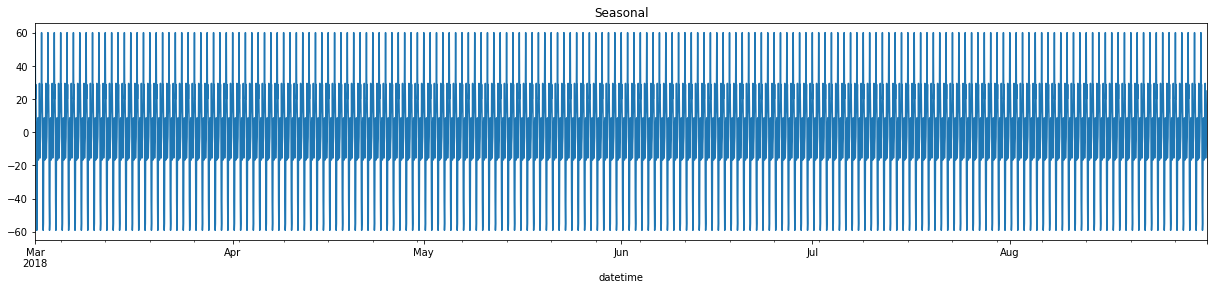

In [14]:
decomposed.seasonal.plot(ax=plt.gca(), figsize=figsize)
plt.title('Seasonal')

### Вывод
С марта по август кол-во заказов увеличивается, т..к ближе к лету люди чаще начинают вылетать из аэропорта, поэтому в признаках модели необходимо будет указать месяц.
Также наблюдается увеличение числа заказов к концу месяца и в определенные дни недели, поэтому в признаках укажем числа.
В рамках одного дня также наблюдается некоторая сезонность во времени, поэтому необходимо в признаки включить также и часы.
В имеющихся данных мы произвели чистку данных от выбросов, чтоб они не влилияли на корректность модели


## Обучение

In [15]:
# напишем фукцию для создания признаков (мнсяц, день, час, день недели)

def make_features(df, max_lag, rolling_mean_size):
    df = data.copy()
 
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek  
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

### Линейная регрессия

In [16]:
#обучим модель и найдем наилучшие параметры. В цикле использую уже подобранные интервалы

best_rmse_lg = 48

for max_lag in range(33, 35):
    for rolling_mean_size in range(9, 12):
        df = make_features(data, max_lag, rolling_mean_size)
        
        train, test = train_test_split(df, shuffle=False, test_size=0.10)
        train, valid = train_test_split(train, shuffle=False, test_size=0.10)
        train = train.dropna()

        features_train_lg = train.drop('num_orders', axis=1)
        target_train_lg = train['num_orders']

        features_valid_lg = valid.drop('num_orders', axis=1)
        target_valid_lg = valid['num_orders']

        model_lg = LinearRegression()
        model_lg.fit(features_train_lg, target_train_lg)
        predictions_lg = model_lg.predict(features_valid_lg)
        
        rmse_lg = mean_squared_error(target_valid_lg, predictions_lg) ** 0.5
        
        if rmse_lg < best_rmse_lg:
            best_rmse_lg = rmse_lg
            best_max_lag_lg = max_lag
            best_rolling_mean_size_lg = rolling_mean_size
            
print('лучшее RMSE =', best_rmse_lg, 'при lag', best_max_lag_lg, 'и rolling', best_rolling_mean_size_lg)

лучшее RMSE = 33.91458660157781 при lag 34 и rolling 11


### Дерево решений

In [17]:
#обучим модель и найдем наилучшие параметры. В цикле использую уже подобранные интервалы

best_rmse_tr = 48

for max_lag in range(1, 3):                 
    for rolling_mean_size in range(1, 3):
        for max_depth_tr in range(3, 6):
            df = make_features(data, max_lag, rolling_mean_size)
            
            features_train_tr = train.drop('num_orders', axis=1)
            target_train_tr = train['num_orders']

            features_valid_tr = valid.drop('num_orders', axis=1)
            target_valid_tr = valid['num_orders']


            model_tr = DecisionTreeRegressor(max_depth=max_depth_tr, random_state=123)
            model_tr.fit(features_train_tr, target_train_tr)
            predictions_tr = model_tr.predict(features_valid_tr)
        
            rmse_tr = mean_squared_error(target_valid_tr, predictions_tr) ** 0.5
        
            if rmse_tr < best_rmse_tr:
                best_rmse_tr = rmse_tr
                best_max_lag_tr = max_lag
                best_rolling_mean_size_tr = rolling_mean_size
                best_max_depth_tr = max_depth_tr
            
print('лучшее RMSE =', best_rmse_tr, 'при lag', best_max_lag_tr, 'rolling', best_rolling_mean_size_tr, 'depth', best_max_depth_tr)


лучшее RMSE = 39.29688867114967 при lag 1 rolling 1 depth 5


###  LightGBM

In [18]:
""" закомментировала процесс, т..к он долгий. Полученные результаты использую на тесте

#обучим модель и найдем наилучшие параметры. В цикле использую уже подобранные интервалы

best_rmse_lgbm = 48

for max_lag in range(100, 120):                 
    for rolling_mean_size in range(5, 7):
            df = make_features(data, max_lag, rolling_mean_size)
            
            features_train_lgbm = train.drop('num_orders', axis=1)
            target_train_lgbm = train['num_orders']

            features_valid_lgbm = valid.drop('num_orders', axis=1)
            target_valid_lgbm = valid['num_orders']


            model_lgbm = LGBMRegressor(random_state=123)
            model_lgbm.fit(features_train_lgbm, target_train_lgbm)
            predictions_lgbm = model_lgbm.predict(features_valid_lgbm)
        
            rmse_lgbm = mean_squared_error(target_valid_lgbm, predictions_lgbm) ** 0.5
        
            if rmse_lgbm < best_rmse_lgbm:
                best_rmse_lgbm = rmse_lgbm
                best_max_lag_lgbm = max_lag
                best_rolling_mean_size_lgbm = rolling_mean_size
                
            
print('лучшее RMSE =', best_rmse_lgbm, 'при lag', best_max_lag_lgbm, 'rolling', best_rolling_mean_size_lgbm)"""


" закомментировала процесс, т..к он долгий. Полученные результаты использую на тесте\n\n#обучим модель и найдем наилучшие параметры. В цикле использую уже подобранные интервалы\n\nbest_rmse_lgbm = 48\n\nfor max_lag in range(100, 120):                 \n    for rolling_mean_size in range(5, 7):\n            df = make_features(data, max_lag, rolling_mean_size)\n            \n            features_train_lgbm = train.drop('num_orders', axis=1)\n            target_train_lgbm = train['num_orders']\n\n            features_valid_lgbm = valid.drop('num_orders', axis=1)\n            target_valid_lgbm = valid['num_orders']\n\n\n            model_lgbm = LGBMRegressor(random_state=123)\n            model_lgbm.fit(features_train_lgbm, target_train_lgbm)\n            predictions_lgbm = model_lgbm.predict(features_valid_lgbm)\n        \n            rmse_lgbm = mean_squared_error(target_valid_lgbm, predictions_lgbm) ** 0.5\n        \n            if rmse_lgbm < best_rmse_lgbm:\n                best_rmse_

### Вывод
Было построено три модели Линейная регрессия, Дерево решений и LightGBM.
Наилучший вариант с RMSE = 27,89 показала модель LightGBM

## Тестирование

In [16]:
# проверим модель LightGBM на тестовой выборке

df = make_features(data, 100, 5)

train, test = train_test_split(df, shuffle=False, test_size=0.10)
train = train.dropna()

features_train_ = train.drop('num_orders', axis=1)
target_train_ = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

model_test = LGBMRegressor()
model_test.fit(features_train_, target_train_)
predictions_test = model_test.predict(features_test)

rmse_test = mean_squared_error(target_test, predictions_test) ** 0.5
print(f'RMSE на тестовой выборке: {rmse_test}')

RMSE на тестовой выборке: 38.73971722407821


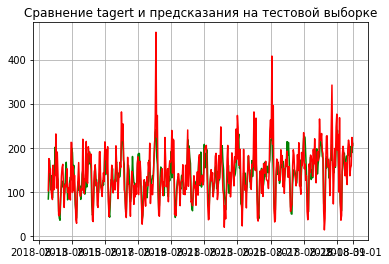

In [17]:
plt.title('Сравнение tagert и предсказания на тестовой выборке')

plt.plot(target_test.index, predictions_test, 'g', label='Предсказание на тестовой выборке')
plt.plot(target_test.index, target_test.values, 'r', label='Target тестовой выборки')
plt.grid(True)


### Вывод
В предоставленных данных было 2 колонки: дата+время и общее кол-во заказов. Данные представлены за пол года с 03.2023 по 08.2023. Пустых значений не было. Колонку datetime привели к временному индексу. Данные ресемплированы по 1 часу для создания модели, которая сможет прогнозировать общее кол-во заказов в течение часа.

При анализе данных мы обнаружили несколько закономерностей (тренд, сезонность) в месяцах, числах, днях недели и времени заказа, поэтому для обучения модели мы создадим признаки с этими данными. 

Было создано 3 модели Линейная регрессия, Дерево решений и LightGBM. Наилучший результат с RMSE = 27,89 показала модель LightGBM. При проверке модели LightGBM на тестовой выборке RMSE = 46.95, что соотвтетсует условию задания, а именно RMSE < 48. В связи с чем делаю вывод, что модель LightGBM рабочая.
